## Background / Motivation

We wanted to work on this problem because we all really love the film Titanic. The Titanic was a British passenger ship which sank on April 15, 1912 after colliding with an iceberg. It was one of the largest and most luxurious ships at the time and considered to be a safe and unsinkable ship. It included amenities such as a swimming pool, gymnasium, and multiple dining options for passengers. This explains why the crew was not prepared for disaster; with 2,224 people on board, there was only enough lifeboats for half of the total amount of people, leading to the death of 1,500. The sinking of the Titanic led to significant changes in maritime safety regulations, including requiring ships to carry enough lifeboats for all passengers and crew and improving communication and navigation systems on board. The Titanic's story has been the subject of numerous books, movies, and documentaries, and has become a symbol of human hubris and the dangers of overconfidence in technology.

We would like to explore which people's lives were prioritized in this state of emergency, and which lives were not. This would give valuable insight into the social structure of British and American society during that time.

## Problem statement 

We would like to predict the survival of the passengers on the Titanic based on features of the passengers such as their class, gender, port of embarkation, cabin number, cost of fare, relatives on board, and age. 

This is a classification problem because we want to figure out whether or not the passengers survived, a qualitative response. This is more of an inference problem since we don't want to necessarily predict future deaths of passengers of the Titanic, something that won't happen again, but instead understand how each indepedent variable impacts the likelihood of that passenger dying. 

Since this is a classification problem, we obviously want to minimize the classification error rate, and hopefully achieve a model of at least 95% accuracy. Since we are not using this data to make any future predictions, we aren't necessarily interested in precision, recall, FNR, or TPR.

## Data sources

The data we used is a Kaggle dataset found at this link: https://www.kaggle.com/competitions/titanic/data?select=test.csv
<br>
<br>
Our variable of interest is 'Survived' and the rest of the variables were considered as predictors. 
<br> 
<br>
Variable descriptions: 
<br> 
<br>
1. Survived: 0=No, 1=Yes
<br> 
2. Pclass: 1 = first class, 2 = second class, 3 = third class
<br> 
3. sibsp: number of siblings and spouses aboard Titanic
<br> 
4. parch: number of parents and children aboard Titanic
<br> 
5. ticket: ticket number
<br> 
6. fare: passenger fare
<br> 
7. cabin: cabin number
<br> 
8. embarked: port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton


## Stakeholders

We are mostly interested in understanding the background of a historical event, and if certain factors like sex or class could have decided on a person's life. This would help honor the victims of this tragic accident.

Additionally, for someone paranoid and scared of boatrides, it might help them feel prepared if they knew what helped people survive on the Titanic, so they could improve their chances of survival through fare, cabin placement, etc. as well

## Data quality check / cleaning / preparation 

The following variables were discarded as they did not provide any unique data; they were specific to each passenger
- PassengerId
- Name
- Ticket
- Cabin

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

train = pd.read_csv('../train.csv')
train = train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

The frequency for the continuous variables is as follows:

In [36]:
df = train[['Age','Fare']].isnull().sum().reset_index().transpose().append(train[['Age','Fare']].nunique().reset_index().transpose())
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df = df.set_index([pd.Index(['# missing','# unique'])])
train[['Age','Fare']].describe().append(df)

Age       Fare
count          714.0      891.0
mean       29.699118  32.204208
std        14.526497  49.693429
min             0.42        0.0
25%           20.125     7.9104
50%             28.0    14.4542
75%             38.0       31.0
max             80.0   512.3292
# missing        177          0
# unique          88        248

The frequency table for the categorical variable "Survived":

In [37]:
df1=pd.crosstab(train['Survived'], columns = 'count')
df2=pd.DataFrame(data={'# missing': [0, ' '], '# unique': [2, ' ']}, index=[0, 1])
pd.concat([df1,df2],axis=1)

count # missing # unique
0    549         0        2
1    342

The frequency table for the categorical variable "Pclass":

In [38]:
df1=pd.crosstab(train['Pclass'], columns = 'count')
df2=pd.DataFrame(data={'# missing': [0, ' ',' '], '# unique': [3, ' ',' ']}, index=[1,2,3])
pd.concat([df1,df2],axis=1)

count # missing # unique
1    216         0        3
2    184                   
3    491

The frequency table for the categorical variable "Sex":

In [39]:
df1=pd.crosstab(train['Sex'], columns = 'count')
df2=pd.DataFrame(data={'# missing': [0, ' '], '# unique': [2, ' ']}, index=['female','male'])
pd.concat([df1,df2],axis=1)

count # missing # unique
female    314         0        2
male      577

The frequency table for the categorical variable "SibSp":

In [40]:
df1=pd.crosstab(train['SibSp'], columns = 'count')
df2=pd.DataFrame(data={'# missing': [0,'','','','','',''], '# unique': [7,'','','','','','']}, index=[0,1,2,3,4,5,8])
pd.concat([df1,df2],axis=1).head(3)

count # missing # unique
0    608         0        7
1    209                   
2     28

The frequency table for the categorical variable "Parch":

In [41]:
df1=pd.crosstab(train['Parch'], columns = 'count')
df2=pd.DataFrame(data={'# missing': [0,'','','','','',''], '# unique': [7,'','','','','','']}, index=[0,1,2,3,4,5,6])
pd.concat([df1,df2],axis=1).head(3)

count # missing # unique
0    678         0        7
1    118                   
2     80

The frequency table for the categorical variable "Embarked"

In [42]:
df1=pd.crosstab(train['Embarked'], columns = 'count')
df2=pd.DataFrame(data={'# missing': [0,'',''], '# unique': [3,'','']}, index=['C','S','Q'])
pd.concat([df1,df2],axis=1)

count # missing # unique
C    168         0        3
Q     77                   
S    644

The only data cleaning necessary for this dataset was the values of Age -- there were 177 missing values, and there was enough information for me to impute them. In order to impute the 177 values of Age, I decided to run a linear regression on all of the other variables and figure out if there was a model that could reliably predict values of Age. Hence, I made a model with Pclass, Sex, SibSp, Parch, Fare, and Embarked. I did some preliminary data analysis on those 6 variables on Age, and found that there was significant correlation between SibSp, Parch, and Pclass, but not Sex or Embarked. This is probably because Sex and Embarked would have a pretty evenly split age groups. The specific correlations can be seen in the Code section. 

To impute the values, I split the entire training dataset into two: one with all of the ages, and one without all of the ages. I ran my multiple linear regression on the dataset with all of the equations. I also edited the dataframe so that the variables SibSp, Parch, and Pclass were strings instead of integers, in order for the model to read them as categorical variables. I found that doing this improved the R-squared of my model drastically. I believe this is because these three variables only have discrete values (you can't have 4.5 siblings). I initially used the formula 'Age~SibSp+Parch+Pclass+Fare', and performed a residual analysis, as I found the R-squared value of 0.302 to be a bit unsatisfactory.

In [43]:
train['Pclass'] = train['Pclass'].apply(str)
train['Parch'] = train['Parch'].apply(str)
train['SibSp'] = train['SibSp'].apply(str)
missing_age = train[train['Age'].isna()] #dataframe containing only rows missing Age
has_age = train.dropna(subset=['Age']) #dataframe containing only no rows missing Age
ols_object = smf.ols(formula = 'Age~SibSp+Parch+Pclass+Fare', data = has_age)
model = ols_object.fit()
plt.rcParams["figure.figsize"] = (5,3)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [0,55],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

Here, you can clearly see that the constant variance assumption is violated, and hence we must take a transformation of the response variable. I found that taking the square-root of age was able make the variance of the residuals a bit more constant.
Doing so improved the R-squared of this model to 0.349. As a last step, I checked to see if there were a need to remove any outliers, high leverage points, and influential points. I found 4 outliers, 35 high leverage points, and no influential points. Because there were no influential points, I decided not to remove any data from the model.

Text(0, 0.5, 'Residuals')

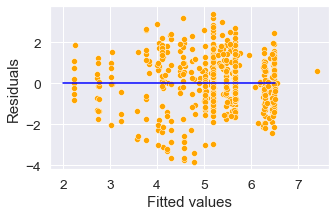

In [10]:
ols_object = smf.ols(formula = 'np.sqrt(Age)~SibSp+Parch+Pclass+Fare', data = has_age)
model_sqrt_age = ols_object.fit()
plt.rcParams["figure.figsize"] = (5,3)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model_sqrt_age.fittedvalues, y=model_sqrt_age.resid,color = 'orange')
sns.lineplot(x = [2,6.5],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

With this final model now set, I was now ready to impute the data on the part of the dataset that did not have values of Age. However, I immediately ran into an issue -- 7 datapoints had "SibSp" values of 8, but my model could only predict Ages of those with "SibSp" values from 0 to 5. Since "SibSp" has to do with the number of siblings and spouses, I hypothesized that the people who had a "SibSp" of 8 probably belonged to the same large family. I looked for these values in the dataframe and was correct! They call came from the Sage family.

In [11]:
train = pd.read_csv('../train.csv')
missing_age = train[train['Age'].isna()]
missing_age.loc[missing_age['SibSp']==8]

PassengerId  Survived  Pclass                               Name     Sex  \
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
324          325         0       3           Sage, Mr. George John Jr    male   
792          793         0       3            Sage, Miss. Stella Anna  female   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

     Age  SibSp  Parch    Ticket   Fare Cabin Embarked  
159  NaN      8      2  CA. 2343  69.55   NaN        S  
180  NaN      8      2  CA. 2343  69.55   NaN        S  
201  NaN      8      2  CA. 2343  69.55   NaN        S  
324  NaN      8      2  CA. 2343  69.55   NaN        S  
792  NaN      8      2  CA. 2343  69.55   NaN        S  
846  NaN      8      2  CA. 2343  69.55   NaN        S  
863  NaN      8      2  CA. 2343  69.55   NaN        S

Since there were so few values, I decided to see if I could do enough historical research to hand impute these values. Indeed, I was able to find the birth years of all of the passengers, due to the fact that this historical event has a lot of research and archived materials. I was able to find: Stella (born 1891), George John (born 1892), Douglas Bullen (born 1894), Frederick (born 1895), Dorothy Florence (born 1897), Anthony William (born 1899), Elizabeth Ada (born 1901), Constance Gladys (born 1904), and Thomas Henry (born 1911). [1] With the fact that the Titanic sank in 1912, I was able to figure out their ages! 

## Exploratory data analysis

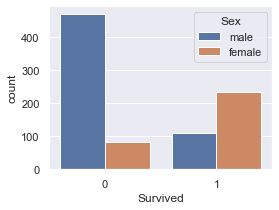

In [12]:
from IPython.display import Image
Image(filename='EDA1.png') 

From this, we find that the majority of people who died are men, and the majority of people who survived are female

In [13]:
Image(filename='EDA2.png') 

From this, we see that the majority of people who died was in the third class, but those who survived seem pretty evenly split between all classes

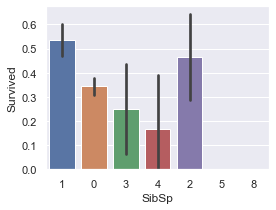

In [14]:
Image(filename='EDA3.png') 

From this, we find that smaller families are more likely to survive than larger families

In [15]:
Image(filename='EDA4.png') 

From this, we find that there is some variation on survival rate based on which city they embarked on, which may be due to a correlation with class.

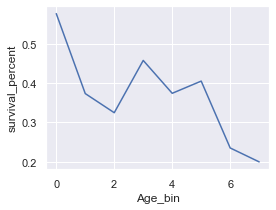

In [16]:
Image(filename='EDA5.png') 

From here, we find that the older the passenger, the less likely they were able to survive.

## Approach

We chose to use a logistic model, as we were performing a classification task. As we developed this model, we chose to optimize overall accuracy, as the purpose of this analysis is to gain insight into the factors that lead to survival or death in these circumstances. If this were a more modern or common distaster it may be useful to use this information to inform modern ships about survival risks, but due to the unique circumstances and era we simply seek to understand the factors contributing to survival for this specific situation, leading to the pursuit of overalll accuracy. It is important to note that we also sought to balance the precision and recall for both factors, as we had a relatively high proportion of the data belonging to a single category (65% fatality rate)

After data cleaning and imputation, early modeling efforts focused on first identifying factors that, on their own, were significant predictors of survival. Here we first encountered a problem then would endure throughout our analysis: a significant quantity of cateorical data, for which it was difficult to isolate the impact and compare to numerical data. To get a better general understanding of our variables and identify what could ask as the bases of our model we first made single variable logistic regression for each of our variables, as shown below. 

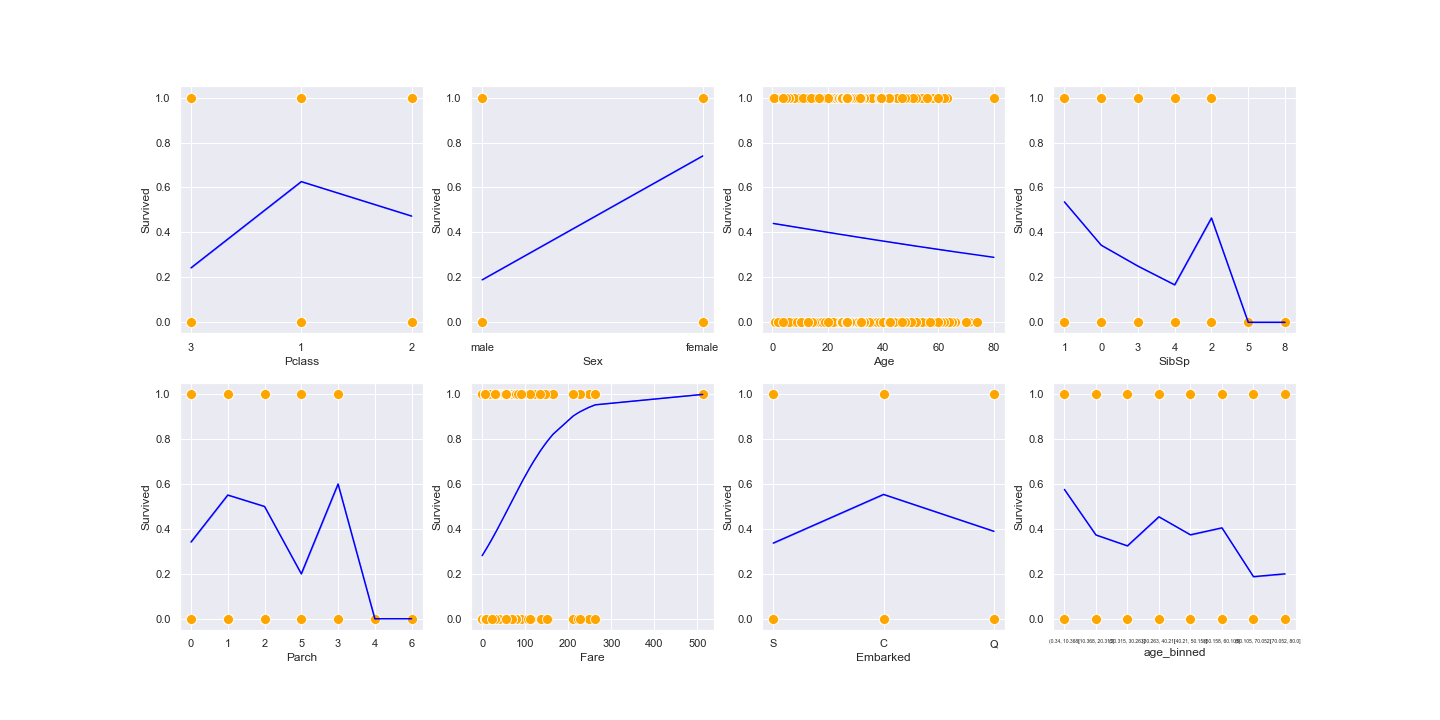

In [17]:
Image(filename='preliminary.png') 

As shown below, there are several factors that appear to have a significant correlation with survival rate, with sex being the most powerful. Sex as a solo variable cound be considered our first model and although it does have a high correlation, there are many other effects clearly at play - both SibSp and Parch, measures of family size, have significant (and opposite) efects. Fare and class, both a measure of the socioeconomic standing of the passenger, have higher survival at high fare/high class. The age variable shows higher survival at lower age, but the binned age variable shows that this is inconsistant among age groups, and primarily applies to the young. The next step was to integrate multiple variables together. The plot below shows all possible combination of variables (with no interaction), by their pseudo r-squared, the first metric we considered.

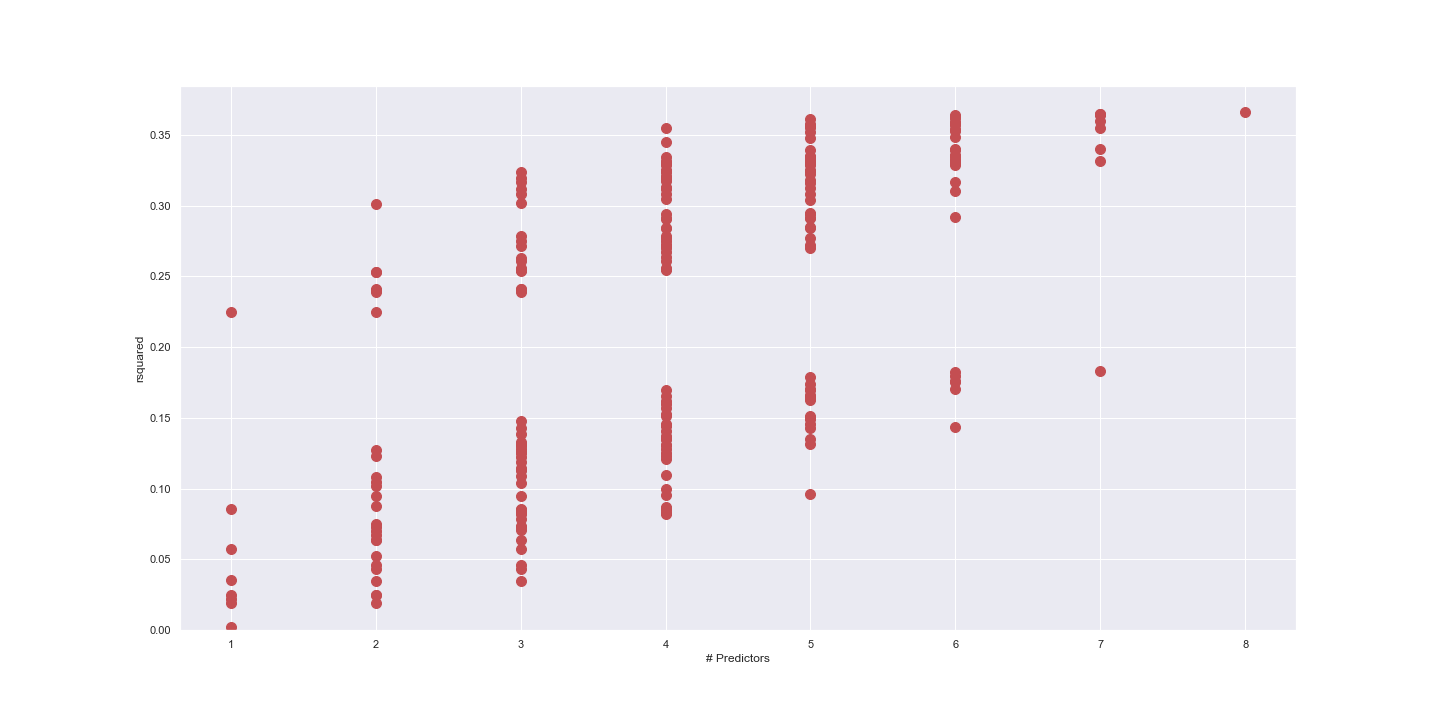

In [18]:
Image(filename='rsquared_all_models.png')

This process re-emphasized the imapact of sex as a predictor, with all models in the top group (pseudo rsquared > 0.2) including sex as a predictor, and all below lacking. Here we can see that there were diminishing returns of best model rsquared after 4 predictors were included. Further analysis while developing the model will use metrics such as RSS to focus in on the best model in this range. 

Overall, we beleive we took a relatively standard approach to this problem, drawing form the work we did throughout or course material, this being the only major source of code. We adapted out work down with linear regression variable selection to perform this variable selection for classification, making changes when needed, keeping it in a format that was accessible to continued evauation of models. This is an active kaggle prediction problem, and the posted code generally was very preliminary analysis that had scores falling short of the results of our analysis, thus we did not draw from this as a source. Although there were entries in the competitions with scores as high as 1

## Developing the model

Our first approach was to develop a basic model with variables found to have a relationship with the target variable based on the EDA and data processsing. This model included the following predictors: **Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + age_binned**. From the model summary, it appeared that many of the predictors were insignificant despite the model's LLR-pvalue being indicating model significance. 

Before moving on to improving the model, we used Sklearn train_test_split to test the classification accuracy of the data as a reference point for future models. The resulting classification accuracy was **0.7910**.

---


The first steps we took to improve the model was to run best subset exhaustive feature selection on our data. We discovered that these 6 predictors are the most significant predictors: **Pclass, Age, SibSp, Parch, Embarked, Sex** and the resulting classification accuracy was **0.7985**.

---

This feature selection increased the model accuracy  and gave us a smaller subset of predictors to further observe.// Allowed us to reduce the amount of predictos without negatively affecting the accuracy. Next, we decided to perform variable transformations on this subset of predictors to futher maximize the classification accuracy.

We included three variable transformations in our model. The first transformation was between the variables SibSp and Parch. Both of these variables describe family relationships and both count members of family members. Since they measure very similar things which also rely on each other, creating an interaction term made sense and seemed to improve the classification accuracy of our model.


The second variable transformation we included in our model was between class and point of embarkation. This transformation was included based on the distribution of class and embarkation observed in the following countplot.



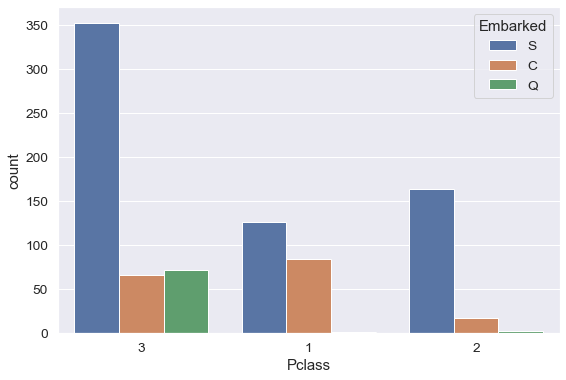

In [19]:
Image(filename='embarkedxpclass_countplot.png') 

The final variable transformation we included in our model was between class and age. We suspected that age and class may have a significant relationship because we anticipated that older individuals may have more wealth than younger individuals. To further back up this intution, we observed the correlations between these two variables, which was roughly 0.45. After including this transformation, we saw a further increase in the classification accuracy. 

We succeeded in achieving our goal because the classification accuracy increased to **0.8060**. In addition to the accuracy, we also printed a Precision of 0.87 and a recall of 0.83 when predicting whether a patient would have not survivied.

---



However, we wanted to see if we could improve these results even more. Therefore, we run another variable selection, but this time including all possible two fold interactions between the varaibels. As a extensive subset selection took too long for that, however, we decided to run a forward selection instead. Then, we chose the predictors that left the lowest BIC value, which were **Age_Sex,Pclass_SibSp,Pclass_Embarked,Parch,Age_Parch,SibSp,Pclass_Parch,Fare_Sex**. Using this set of predictors, we were able to improve our accuracy even more, to **0.8289**. With the following confusion Matrix, we also found that while Precision had decreased a bit, to 0.84, recall was not at 0.88. Therefore, we decided that this was our best model.

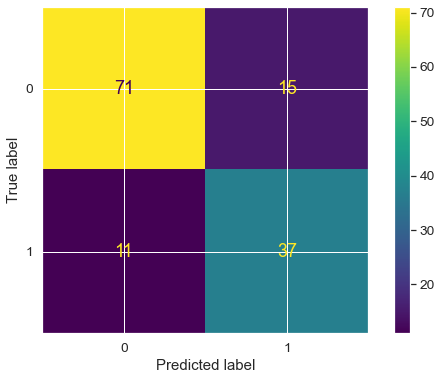

In [20]:
Image(filename='cm.png') 

---

**The final model equation:** 

Survived_hat = 1.3554821+ -0.08183318Age_Sex + -0.8977917Pclass_SibSp + -0.17944044Pclass_Embarked + 1.26342561Parch + -0.01509503Age_Parch + 1.86909341SibSp + -0.29326558Pclass_Parch + 0.0022371Fare_Sex


## Limitations of the model with regard to inference / prediction

As we are looking at a historical event for this inference task, this inference can only be expected to hold in that particular era, with the particular combination of high and low class citizens that was found aboard the RMS titanic. Upon completing analysis, however, it becomes clear that the cultural differences between now and then are likely not extreme; although the world has changed significantly in the 111 years since the sinking of the titanic, many cultural values remian. We would stil expect women and children to be prioritized in a survival situation, with those values still ingrained in our culture. It is likely that class would play a role, although hopefully our society has developed enough to have better equity in this regard. 

Although our inference is specialized to this unique place and time, the cultural insights are applicable even now, and it would be fascinating to find similar data for modern day disasters and determine how many of these values remain. As long as these western values (women and children, class) persist our inference still has some connection to the modern day, and I do not think it can be considered obsolete. 

## Conclusions and Recommendations to stakeholder(s)


As we are analyzing a historical event, we do not have any recommendations to present as there are no stakeholders that would significantly benefit from our insights. 

In terms of conclusions, out optimized logistic model summary shows the factors that were the most impactful. The first thing that stands out, as it did throughout our analysis, was the impact of sex on survival. The coefficient for male was -2.7381, with a p-value rounding to ~0. This shows the that the stereotypical prioritization of women in survival situtations is historically accurate, with female survival rate being significantly higher. The second thing, that once again was in line with our expectations, was the dependance on class. The intercept coefficent, corresponding to class 1 passengers, has coefficent of 4.0693 with a p-value ~0 showing that the upper class passengers where able to survive at a significantly higher rate, especially compared to 3rd class (ceof = -1.9166, pval = 0.009). Interestingly the second class coefficient was not singificant, highlighting the gap between the highest and lowest class.

Another aspect that we expected to be significant was Age, to emphasize the expression 'women and children first' that was frequently stated in the movie, and is stereotypical of emergency situations even today. We were able to find a significant decrease in survival with Age (pval = 0.008), but the coefficient was just -0.0349, a lower impact than expected. Bucketing age did not appear useful, although in early analysis showed that this trend (lower survival with age) is not consistent across age groups. Another factor that may give insight into this area is the factors SubSp, and Parch, which show the number of siblings aboard and number of parents and children. The former was shown to have a moderate impact of -0.3319, with a pvalue 0.004. This indicates that larger families (children on board with more siblings) had more difficulty surviving, potentiall skewing the age to have less impact than expected. 

Other factors lead to improved modeling outcomes, but did not carry significant in the model, making their impact less intuitive to understand. In general our analysis found that the stereotypical prioritization of women and children appears to exist, but gender seems to be a much larger predictor than age. Class was shown to be second only to gender, showing how even in crisis, those with higher class are able to secure better outcomes. These factors give insight into human nature, and confirm many aspects of people are traditional thought to react in emergencies. 

Overall, our model stil has shortcomings, with a recall of just 0.68, showing the difficulty in correctly identifying survived passengers when a clear majority did not survie, and in an emergency situation things are inherently unpredictable, to a degree. If this model were to be improved further, the focus would be on the precisions and recall for the survival values, as those are the minority. 

## GitHub and individual contribution {-}

Github link: https://github.com/davenator-git/Data_Science_303-2_Venator/tree/main

<html>
<style>
table, td, th {
  border: 1px solid black;
}

table {
  border-collapse: collapse;
  width: 100%;
}

th {
  text-align: left;
}
    

</style>
<body>

<h2>Individual contribution</h2>

<table style="width:100%">
     <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 20%;">
       <col span="1" style="width: 50%;">
       <col span="1" style="width: 15%;"> 
    </colgroup>
  <tr>
    <th>Team member</th>
    <th>Contributed aspects</th>
    <th>Details</th>
    <th>Number of GitHub commits</th>
  </tr>
  <tr>
    <td>Jazmyn Lu</td>
    <td>Data cleaning and EDA</td>
    <td>Cleaned data to impute missing values and developed visualizations to identify appropriate variable transformations.</td>
    <td>9</td>
  </tr>
  <tr>
    <td>David Venator</td>
    <td>Variable Selection </td>
    <td>Ran various variable selection algorithms and did some exploration into what variables would be good to add into the model</td>
    <td>12</td>
  </tr>
    <tr>
    <td>Hiba Khatib and Emily Leibfritz</td>
    <td>Exhaustive Variable Selection, minimal data cleaning, fitting models, performance measurement</td>
    <td>Formulated final model and ran performance measurements on both testing and training data, fitting final model</td>
    <td>9 for Hiba, 7 for Emily</td>    
  </tr>
</table>

We were all pretty comfortable using GitHub, and did not face many challenges on the GitHub side. We thought to coordinate carefully who was going to be changing what, and made sure that we did not have any overlapping sections. 

## References {-}

[1] The National Archives, “Stories from the Titanic - Safe Family,” 01-Mar-2012. [Online]. Available: https://www.nationalarchives.gov.uk/titanic/stories/sage-family.htm. [Accessed: 3-Mar-2023]. 